In [3]:
cd(@__DIR__) #src
using Agents, Random
using Agents.DataFrames, Agents.Graphs
using Distributions: Poisson, DiscreteNonParametric
using DrWatson: @dict
using CairoMakie
CairoMakie.activate!() # hide

using InteractiveDynamics
using StatsBase
using ColorSchemes
using DataStructures
using VegaLite
using DataFrames

In [4]:

#We initialize the model according to some parameters.
function  model_init(;pr,dr,mr,seed,l,n0,ngenes,fitness)
    @agent Cell GridAgent{2} begin
        time_alive::Int  # Time the cell has been alive
        near_cells::Int # Number of cells in the neighborhood
        genotype::BitArray # Genotype of the cell
    end

    
    rng = MersenneTwister(seed)

    space = GridSpace((l, l))
    properties=@dict(ngenes,pr,dr,mr,fitness)
    model = ABM(Cell, space;properties, rng) 

    for i in 1:n0
        #add_agent!(model,0,0,BitArray([false for x in 1:ngenes])) #With this one we generate at random over the grid
        add_agent!((Int(floor(l/2)),Int(floor(l/2))),model,0,0,BitArray([false for x in 1:ngenes])) #With this we generate all of them at the middle point
    end
    return model
end

#Function to get the number of cells "near" each cell. As i dont know what should count as near (only the space or a mean of the 8 surrounding spaces? for example) i prefer to define it in a single place and then change it.
function get_near!(agent,model)
    length(ids_in_position(agent, model))
end

#Step evey agent, updating its parameters and then reproducing, moving and dying.
function agent_step!(agent, model)
    if agent.time_alive == 0
        mutate!(agent,model)
    end
    agent.time_alive += 1
    agent.near_cells = get_near!(agent,model)
    reproduce!(agent, model)
    move!(agent, model)
    die!(agent, model)
end

#with a probability p choose a random non mutated gene and mutate it.
function mutate!(agent,model)
    genes=findall(agent.genotype .!=1)
    if genes!=[] && rand(model.rng) < model.mr
        agent.genotype[rand(genes)]=true
    end
end

#reproduce, creating a new cell in the same space with a probability that decreases with how many cells are already in its space
function reproduce!(agent,model)
    pr = model.pr*model.fitness[bit_2_int(agent.genotype)]
    pid = agent.pos
    newgenom = copy(agent.genotype)
    if rand(model.rng) < pr/(get_near!(agent,model)^2)
        add_agent!(pid,model,0,0,newgenom)
    end
end

#Move every cell to a random nearby space ONLY if your space is "crowded", crowded for example is more than 1 cell in your space 
function move!(agent, model)
    pos = agent.pos
    nearby = [x for x in nearby_positions(agent,model,1)]
    newpos = rand(model.rng, nearby)
    if length(ids_in_position(agent, model)) > 1
        move_agent!(agent,newpos, model)
    end
end

#die, with a probability that increases with the number of cells that are in its space.
function die!(agent, model)
    pos = agent.pos
    nearby = [x for x in nearby_positions(agent,model,1)]
    if rand(model.rng) < model.dr*(get_near!(agent,model)^2)
        kill_agent!(agent, model)
    end
end

#A generator that returns a list of functions that each get the number of cells of each genotype given a number of genes.
function genotype_fraction_function_generator(ngenes)
    functions = []
    for i in 0:((2^ngenes)-1)
        compare = digits(i, base=2, pad=ngenes)
        func = function get_perc(x)
            len = length(findall([string(y)[5:end] for y in x] .== string(compare)))
            return len
        end
        push!(functions,func)
    end
    return functions
end

#Function to go from BitArray to Int. Taken from https://discourse.julialang.org/t/parse-an-array-of-bits-bitarray-to-an-integer/42361/5
function bit_2_int(arr)
    arr = reverse(arr)
    sum(((i, x),) -> Int(x) << ((i-1) * sizeof(x)), enumerate(arr.chunks))
end


bit_2_int (generic function with 1 method)

In [21]:
#Todavia no entiendo por qué, pero hay que correr primero una vez esta celda, da eror y luego las siguientes veces que la corres ya va bien.

ngenes=3 #Number of genes of each cell. We need to define it earlier in order to collect the data. Can go up to 100000 easily AS LONG as we dont measure in every timestep.

#
# Ejemplo AND con 3 genes:
#
#  WT             000:WT  ->1
#  /\             001:C   ->0
# A  B            010:B   ->1.2
#  \/ (and)       011:BC  ->0
#   C             100:A   ->1.3
#                 101:AC  ->0
#                 110:AB  ->1.5
#                 111:ABC ->2
#

fitness=Dict(0=>1, #Fitness of each of the genotypes, the key is the binary representation of the genotype in decimal form.
            1=>0, #Fitness is expressed as a multiplicative effect on pr, but this can be changed.
            2=>1.2,
            3=>0,
            4=>1.3,
            5=>0,
            6=>1.5,
            7=>2)
            
fitness=DefaultDict(1,fitness) #If a genotype fitness is not specified, it can have a default value (0 for not viable or 1 for no effect from pr, i need to see which one reduces the size more)

model = model_init(pr=0.027, #Proliferation rate
                    dr=0.015, #Death rate
                    mr=0.01, #Mutation rate
                    l=100, #Lenght of the lxl grid
                    n0=10, #Number of initial WT cells (They dont need to be WT, we can specify any genotype for any of them)
                    ngenes=ngenes, #The number of genes of each cell
                    fitness=fitness, #The fitness of each genotype
                    seed=0) #Seed to get reproducible results

println(model)

#we collect the number of cells that are alive
to_collect = [(:genotype, f) for f in genotype_fraction_function_generator(ngenes)]

#we run the simulation
steps=1000
data, _ = run!(model, agent_step!, steps; adata = to_collect)

#we rename the columns to get a clean "data" DataFrame.
genotypes = [string(digits(i, base=2, pad=ngenes)) for i in 0:((2^ngenes)-1)]
pushfirst!(genotypes,"step")
rename!(data,genotypes)

AgentBasedModel with 10 agents of type Cell
 space: GridSpace with size (100, 100), metric=chebyshev, periodic=true
 scheduler: fastest
 properties: dr, ngenes, fitness, pr, mr


Row,step,"[0, 0, 0]","[1, 0, 0]","[0, 1, 0]","[1, 1, 0]","[0, 0, 1]","[1, 0, 1]","[0, 1, 1]","[1, 1, 1]"
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,10,0,0,0,0,0,0,0
2,1,10,0,0,0,0,0,0,0
3,2,9,0,0,0,0,0,0,0
4,3,9,0,0,0,0,0,0,0
5,4,9,0,0,0,0,0,0,0
6,5,9,0,0,0,0,0,0,0
7,6,8,0,0,0,0,0,0,0
8,7,8,0,0,0,0,0,0,0
9,8,8,0,0,0,0,0,0,0


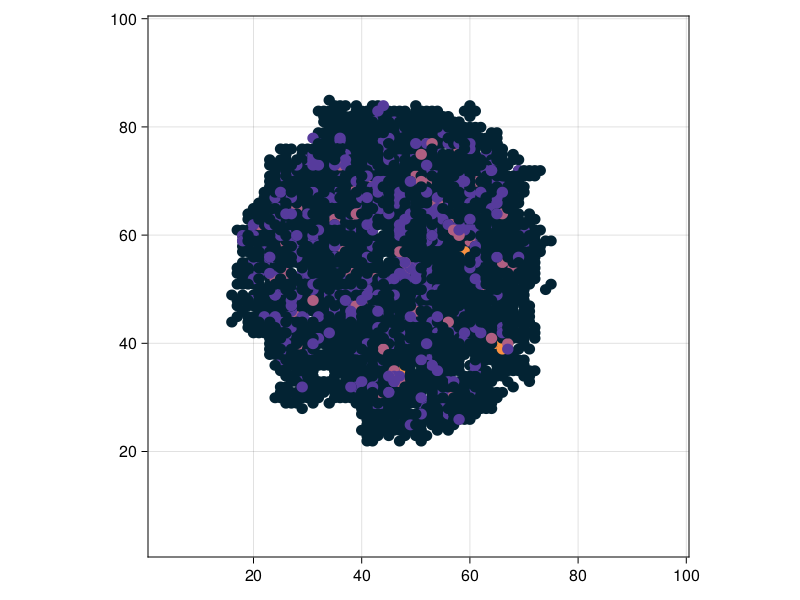

In [22]:
#We plot the "density" of each space in the grid: The number of cells there are in that space.

colors=Dict(0=>:black,1=>:red,2=>:blue,3=>:green,4=>:yellow,5=>:orange,6=>:purple,7=>:pink,8=>:brown,9=>:cyan,10=>:gray)
densitycolor(a) = get(colorschemes[:thermal], a.near_cells, (1,5))

figure, _ = abmplot(model;ac = densitycolor)
figure

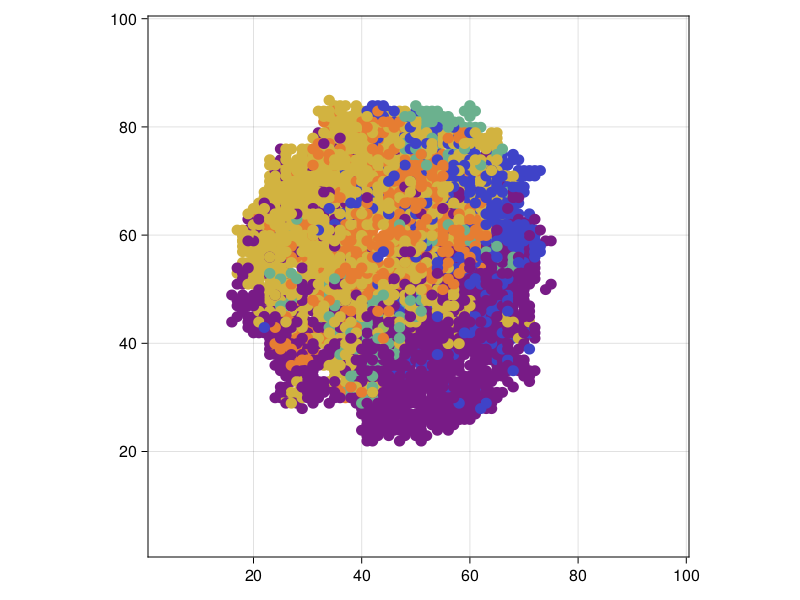

In [23]:
#We plot the genotype of each cell with a different color. Right now the colors dont mean they are similar genotypes.
genotypecolor(a) = get(colorschemes[:rainbow], bit_2_int(a.genotype), (1,8))

figure, _ = abmplot(model;ac = genotypecolor)
figure # returning the figure displays it

0

In [24]:
#We can make a video of the simulations with both colorings!
model = model_init(pr=0.027, #Proliferation rate
                    dr=0.015, #Death rate
                    mr=0.01, #Mutation rate
                    l=100, #Lenght of the lxl grid
                    n0=10, #Number of initial WT cells (They dont need to be WT, we can specify any genotype for any of them)
                    ngenes=ngenes, #The number of genes of each cell
                    fitness=fitness, #The fitness of each genotype
                    seed=0) #Seed to get reproducible results
abmvideo(
    "animations/test_mut_11_11_22_AND_3GENES.mp4", model, agent_step!;
    framerate = 20, frames = 1000,ac = densitycolor,
    title = "Tumor growth"
)

model = model_init(pr=0.027, #Proliferation rate
                    dr=0.015, #Death rate
                    mr=0.01, #Mutation rate
                    l=100, #Lenght of the lxl grid
                    n0=10, #Number of initial WT cells (They dont need to be WT, we can specify any genotype for any of them)
                    ngenes=ngenes, #The number of genes of each cell
                    fitness=fitness, #The fitness of each genotype
                    seed=0) #Seed to get reproducible results
abmvideo(
    "animations/test_gen_11_11_22_AND_3GENES.mp4", model, agent_step!;
    framerate = 20, frames = 1000,ac = genotypecolor,
    title = "Tumor growth"
)

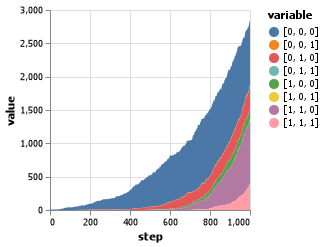

In [25]:
#And lastly we can make plots of both the total number of cells of each genotype
#TODO: Remove the columns that have had no/less than X number of cells to make the legend less crowded.
genotypes = [string(digits(i, base=2, pad=ngenes)) for i in 0:((2^ngenes)-1)]
stacked = stack(data,genotypes)

stacked |>
@vlplot(:area, x=:step, y={:value, stack=:zero}, color="variable:n")

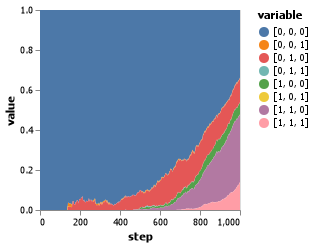

In [26]:
#And the relative number of cells of each genotype
stacked |>
@vlplot(:area, x=:step, y={:value, stack=:normalize}, color="variable:n")